Found 5512 validated image filenames.
Found 6381 validated image filenames.
Found 5174 validated image filenames.
Found 6235 validated image filenames.
Found 7042 validated image filenames.
Total Augmented images created=  219656
Found 249999 files belonging to 5 classes.
Using 225000 files for training.
Found 249999 files belonging to 5 classes.
Using 24999 files for validation.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 ma

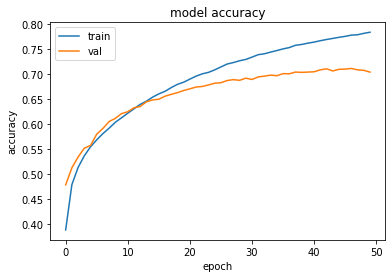

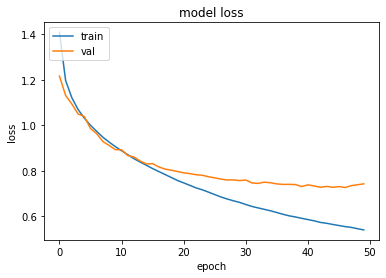

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

import argparse
import dataManagement
from dataManagement import WorkMode, DataSplit
from utils import isValidFile
from argparse import ArgumentParser
from cmath import exp
import csv
import pandas as pd
import h5py
import pickle
import numpy as np
import PIL
import matplotlib.pyplot as plt
import keras
import os
import uuid
from keras import optimizers
from keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
from tensorflow import keras
import os.path
AUGMENTED_DATA_PICKLE = "augmentedData.pickle"
LABELS_PICKLE = "labels.pickle"
WORKING_DIR = os.getcwd()
MODEL_PATH = "classificationModel"

BATCH_SIZE = 128
EPOCHS = 50
BALANCE_AMOUNT = 25000
LEARNING_RATE = 1e-4

# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

def openDB(dbPath):
    db = h5py.File(dbPath, 'r')
    return db

'''
Return a tuple of arrays in the following form:
imageName, image, fonts for that image, words
'''
def readDB(db, mode = dataManagement.WorkMode.Train) -> dataManagement.TestData:
    data = []
    imageNames = sorted(db['data'].keys())
    for i in imageNames:
        name = i
        image = db['data'][i][...]
        charBB = db['data'][i].attrs['charBB']
        fonts = db['data'][i].attrs['font'] if (mode == dataManagement.WorkMode.Train) else None
        text = db['data'][i].attrs['txt']
        if (mode == dataManagement.WorkMode.Train):
            image = dataManagement.TrainData(name, image, fonts, text, charBB)
        else:
            image = dataManagement.TestData(name, image, text, charBB)
        data.append(image)
    return data

'''
Organize and augment data
'''
def organaizeData(data: dataManagement.TrainData, workingDir: str, mode = WorkMode.Train):
    counter=0
    if (os.path.exists(os.path.join(WORKING_DIR, 'dataset' if (mode == WorkMode.Train) else 'datatest'))):
        return
    if (mode == WorkMode.Train):
        dataSet = {"images": [], "filenames": [], "labels": []}
    else: 
        dataSet = {"images": [], "filenames": []}

    counter = 0
    for image in data:
        for i in range(len(image.charImages)):
            label = image.fonts[i] if (mode == WorkMode.Train) else None
            #label = conv_label(label)
            pilImage = []
            try:
                pilImage = image.charImages[i]
            except:
                continue
            # Adding original image
            dataSet['images'].append(pilImage)
            if (mode == WorkMode.Train):
                dataSet['labels'].append(label)
    # save char images in dataset dir
    datasetDir = os.path.join(workingDir, 'dataset' if (mode == WorkMode.Train) else 'datatest')
    try:
        os.mkdir(datasetDir)
    except (FileExistsError):
        print("Dir: {} already exists".format(datasetDir))
    
    if (mode == WorkMode.Train):
        labelsSet = set(dataSet['labels'])
        for label in labelsSet:    
            labelDirPath = os.path.join(datasetDir, str(label)) 
            try:   
                os.mkdir(labelDirPath)
            except (FileExistsError):
                print("Dir: {} already exists".format(labelDirPath))

    if (mode == WorkMode.Train):
        for image, label in zip(dataSet['images'], dataSet['labels']):
            fileName = "img_" + str(uuid.uuid4()) + ".jpg"
            labelDir = os.path.join(datasetDir, str(label))
            imageFileName = os.path.join(labelDir, fileName)
            image.save(imageFileName)
            dataSet["filenames"].append(imageFileName)
    else:
        for image in dataSet['images']:
            fileName = "img_" + str(uuid.uuid4()) + ".jpg"
            imageFileName = os.path.join(datasetDir, fileName)
            image.save(imageFileName)
            dataSet["filenames"].append(imageFileName)
        
    dataSet.pop('images')
    return pd.DataFrame(dataSet)

'''
Augmentation methods
'''


def augmentAndBalance(dataSet: dict, n: int, workingDir: str = WORKING_DIR, imgSize: tuple = ((IMAGE_LENGTH, IMAGE_WIDTH))) -> dict:
        datasetDir = os.path.join(workingDir, 'dataset')
        # create and store the augmented images  
        total=0
        dataGenerator=ImageDataGenerator(rotation_range=20, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             shear_range=0.1, 
                             zoom_range=0.08,
                             horizontal_flip=False,
                             fill_mode='nearest')
         
        groups=dataSet.groupby('labels')
        for label in dataSet['labels'].unique():

            # for every group count how many are currently in class
            # if there are less than total desired count
            # generate more by dataGenerator
            group = groups.get_group(label) 
            sampleCount=len(group) 

            if (sampleCount < n): 
                augmentedImageCount = 0

                # Number of images to create
                delta = n - sampleCount
                targetDir = os.path.join(datasetDir, str(label))
                msg = '{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', str(label), str(delta))
                print(msg, '\r', end='') 

                aug_gen=dataGenerator.flow_from_dataframe(group, directory=WORKING_DIR, x_col='filenames', y_col="label", target_size=imgSize,
                                                class_mode=None, batch_size=1, shuffle=True, seed = 42, 
                                                save_to_dir=targetDir, save_prefix='aug-', color_mode='grayscale',
                                                save_format='jpg')
                while augmentedImageCount < delta:
                    images=next(aug_gen)            
                    augmentedImageCount += len(images)
                total +=augmentedImageCount
        print('Total Augmented images created= ', total)

'''
Model
'''
def defineModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_LENGTH, IMAGE_WIDTH, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    return model

def prepareData(workingDir: str, mode: WorkMode, dataSplit: DataSplit):
    # load data and from HD
    dataSet = tf.keras.utils.image_dataset_from_directory(
        os.path.join(workingDir, 'dataset' if (mode == WorkMode.Train) else 'datatest'),
        validation_split = 0.1 if (mode == WorkMode.Train) else None,
        subset = "training" if (mode == WorkMode.Train and dataSplit == DataSplit.Train) 
                                else "validation" if (mode == WorkMode.Train and dataSplit == DataSplit.Validation) else None,
        color_mode='grayscale',
        label_mode='categorical' if (mode == WorkMode.Train) else None,
        seed=42,
        shuffle=True,
        image_size=(IMAGE_LENGTH, IMAGE_WIDTH),
        batch_size=BATCH_SIZE)
    
    AUTOTUNE = tf.data.AUTOTUNE
    dataSet = dataSet.cache().prefetch(buffer_size = AUTOTUNE)
    return dataSet
    
def prepareModelParams(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
    #optimizer = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE)
    model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False), 
                  optimizer=optimizer, metrics=['accuracy'])
    early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min')
    filepath=os.path.join(WORKING_DIR, "top_model.h5")

    checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [early_stopping, checkpoint]
    return callbacks_list

def runModel(model, train_ds, val_ds, callbacks_list):
    history = model.fit(train_ds, shuffle=True,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_data=val_ds,callbacks=callbacks_list)
    score = model.evaluate(val_ds, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return history

def summarizeModelTraining(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


def trainModel(inputFile):
    if (not os.path.exists(os.path.join(WORKING_DIR, 'dataset'))):
        db = openDB(inputFile)
        data = readDB(db)
        df = organaizeData(data, WORKING_DIR)
        augmentAndBalance(df, BALANCE_AMOUNT, WORKING_DIR)

    train_ds = prepareData(WORKING_DIR, mode = WorkMode.Train, dataSplit = DataSplit.Train)
    val_ds = prepareData(WORKING_DIR, mode = WorkMode.Train, dataSplit = DataSplit.Validation)

    K.set_image_data_format('channels_last')
    model = defineModel()
    model.summary()
    callback_list = prepareModelParams(model)
    history = runModel(model, train_ds, val_ds, callback_list)
    model.save(MODEL_PATH)
    #sess.close()
    summarizeModelTraining(history)

'''
########################################## TEST RELATED #############################
'''

'''
This method fixes the predictions by the following assumption: 
If more than half of the charachters of the word belong to the same label,
Then all the word must be the same label. 
'''
def majorityWordVoting(predictions, data: dataManagement.TestData):
    predIndex = 0
    for image in data:
        # extract text saved
        for word in image.text:
            wordLength = len(word)
            # get the font predictions from predictions array
            wordFonts = predictions[predIndex:predIndex + wordLength]
            unique, counts = np.unique(wordFonts, return_counts=True)
            maxCount = np.argmax(counts)
            predictions[predIndex:predIndex + wordLength] = np.full(wordLength, unique[maxCount])
            predIndex += wordLength
    return predictions


def writeOutputCSV(outputFilePath, data: dataManagement.TestData, predictions):
    fontNames = ["Alex Brush", "Open Sans", "Sansation", "Ubuntu Mono", "Titillium Web"]
    outputData = []
    imageNameArray = []
    charArrayResult = []
    fontsResult = np.array([[]])
    predIndex = 0
    for image in data:
        charArray = [char.replace(',', ",") if isinstance(char, str) else char for word in image.text for char in word.decode()]
        charArrayResult = np.concatenate((charArrayResult, charArray))
        imageNameArray = np.concatenate((imageNameArray, np.full(len(charArray), image.name)))
        imageFonts = predictions[predIndex:predIndex + len(charArray)]
        fontsPerChar = np.full((len(imageFonts), 5), 0)
        for i in range(len(imageFonts)):
            fontsPerChar[i, imageFonts[i]] = np.full(1, 1)
        predIndex += len(charArray)
        if (fontsResult.size == 0):
            fontsResult = fontsPerChar
        else:
            fontsResult = np.concatenate((fontsResult, fontsPerChar), axis=0)
    outputData = np.concatenate((np.array(charArrayResult).reshape(-1, 1), fontsResult), axis=1)
    outputData = np.concatenate((np.array(imageNameArray).reshape(-1, 1), outputData), axis=1)

    # Write actual csv 
    header = np.concatenate((['image', 'char'], fontNames))
    result = np.vstack((header, outputData))
    with open(outputFilePath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(result)

'''
Font Conversion
'''
def convertPrediction(prediction):
    if prediction == 0: return "Alex Brush"
    if prediction == 1: return "Open Sans"
    if prediction == 2: return "Sansation"
    if prediction == 3: return "Ubuntu Mono"
    if prediction == 4: return "Titillium Web"

def testModel(inputFile, outputFile):
    db = openDB(inputFile)
    data = readDB(db, mode = WorkMode.Test)
    organaizeData(data, WORKING_DIR, WorkMode.Test)
    test_ds = prepareData(WORKING_DIR, mode = WorkMode.Test, dataSplit = DataSplit.Validation)
    # Load Model
    model = tf.keras.models.load_model(MODEL_PATH)
    predictions = model.predict(test_ds)
    fixedPredictions = [np.argmax(row) for row in predictions]
    fixedPredictions = majorityWordVoting(fixedPredictions, data)
    writeOutputCSV(outputFile, data, fixedPredictions)
    

def main(argv):
    '''
    Argument parser
    '''
    parser = ArgumentParser(description="Train and test font classification model")
    group1 = parser.add_argument_group("group1")
    group1.add_argument("-t", action = 'store_true', help = "This option is used to train model using h5 file as an input")
    iFile = group1.add_argument("-i", type = lambda x: isValidFile(parser, x), dest="inputFileTrain",
                        help="Train model using train h5 DB filepath", metavar="FILE")
    
    group2 = parser.add_argument_group("group2")
    group2.add_argument("-p", action = 'store_true', help = "This option is used to predict model using h5 file as an input, and output a csv")
    group2._group_actions.append(iFile)
    group2.add_argument("-o", help = "Output csv file", dest="outputFile")

    # Uncomment for model training
    #args = parser.parse_args(args = ["-t", "-i", "/content/drive/MyDrive/Colab Notebooks/SynthText_train.h5"])

    # Model Test and result
    args = parser.parse_args(args = ["-p", "-i", "/content/drive/MyDrive/Colab Notebooks/SynthText_test.h5", "-o", "/content/drive/MyDrive/Colab Notebooks/result.csv"])

    '''
    Train or test model
    '''
    if (args.t):
        trainModel(args.inputFileTrain)
    elif(args.p):
        testModel(args.inputFileTrain, args.outputFile)

if __name__ == "__main__":
    main(sys.argv[1:])